# Кластеризация антител по последовательности V-доменов

In [2]:
import os
import collections

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# нужен для работы инструмента protencoder
import cv2 

from Bio import SeqIO
from Bio.PDB import *

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.tree import _tree, DecisionTreeClassifier

from IPython.display import display, HTML

## Предобработка данных

In [132]:
# функция для составления списков id тяжёлых и лёгких цепей
def add_chains(h_lst, l_lst, line):
    if line.startswith('REMARK'):
        for word in line.split():
            if word.startswith("HCHAIN"):
                h_lst.append(word[-1])
            elif word.startswith("LCHAIN"):
                l_lst.append(word[-1])
    return

### Получение последовательностей из файлов

Для кластеризации будем использовать вариабельные (V-) домены антител. Отдельно кластеризуем лёгкие и тяжёлые цепи. Нам понадобятся pdb файлы, пронумерованные с использованием Chothia numbering scheme. Оттуда легко достать цепи, содержащие VH и VL фрагменты.

Полученные последовательности цепей записываем в fasta файлы, так как для кодирования будем использовать инструмент *protencoder*, который принимает файлы на входе.

In [4]:
directory = 'chothia'
pdb_parser = PDBParser(QUIET=True)
polypeptide_builder = PPBuilder()

for filename in os.listdir(directory):
    heavy_chains = []
    light_chains = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and filename.endswith('.pdb'):
        for line in open(f, 'r'):
            add_chains(heavy_chains, light_chains, line)
            
        structure = pdb_parser.get_structure(filename[:4], f)
        model = structure[0]
            
        for chain_id in heavy_chains:
            seq = ''
            if chain_id in model:
                chain = model[chain_id]
                
                number = 0
                for r in chain.get_residues():
                    if r.get_id()[1] != 114: # длина VH по Chothia
                        number += 1
                    else:
                        break

                for polypeptide in polypeptide_builder.build_peptides(chain):
                    seq += polypeptide.get_sequence()
                with open('heavy_chains.fasta', 'a') as file:
                    file.write(f">{filename[:4]}_{chain_id}\n" )
                    file.write(str(seq[:number]) + '\n')

        for chain_id in light_chains:
            seq = ''
            if chain_id in model:
                chain = model[chain_id]

                number = 0
                for r in chain.get_residues():
                    if r.get_id()[1] != 108: # длина VL по Chothia
                        number += 1
                    else:
                        break

                for polypeptide in polypeptide_builder.build_peptides(chain):
                    seq += polypeptide.get_sequence()
                with open('light_chains.fasta', 'a') as file:
                    file.write(f">{filename[:4]}_{chain_id}\n" )
                    file.write(str(seq[:number]) + '\n')
                    

### Кодирование последовательностей

Protencoder предоставляет несколько вариантов кодирования последовательностей белков. Мы используем one-hot encoding. Каждая аминокислота представлена 20 цифрами; одна цифра, соответствующая нужной аминокислоте, обозначена как "1", а остальные 19 цифр - нули. Также для каждой аминокислоты добавляются дополнительные девять цифр, представляющие девять физико-химических свойств:
- гидрофобность;
- гидрофильность;
- водородная связь;
- объемы боковых цепей;
- полярность;
- поляризуемость;
- площадь поверхности, доступной для растворителя;
- индекс чистого заряда боковых цепей;
- средняя масса аминокислоты.

In [135]:
# команды для работы с protencoder
# на выходе получаем numpy файлы с закодированными последовательностями и txt файлы с индексами (названиями последовательностей)
!protencoder -d heavy_chains.fasta -M o -m 130 -s 7000 -c heavy_chains_encoded.txt -n 1000 -o heavy_output
!protencoder -d light_chains.fasta -M o -m 120 -s 7000 -c light_chains_encoded.txt -n 1000 -o light_output

C:\Users\pirit\.conda\envs\protein-env\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pirit\.conda\envs\protein-env\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# функции для удобного отображения Decision Tree

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: 
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]

            left_rule = current_rule + ["({} <= {})".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)

            right_rule = current_rule + ["({} > {})".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: 
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)

            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() 
    return class_rules_dict 

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

## VH-фрагменты

In [4]:
# загружаем наши данные из полученных numpy файлов

vh_np_array = np.load('heavy_output_part1_onehot.npy')
vh_np_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
# загружаем индексы из текстовых файлов

vh_indices = []

with open('heavy_output_part1_keys.txt', 'r') as file:
    for line in file:
        vh_indices.append(line.rstrip('\n'))
    
#vh_indices

Составляем заголовки для колонок.
Буква - краткое обозначение аминокислоты или её свойства.
Цифра - положение в последовательности цепи.

In [6]:
vh_columns = []

for i in range(1, 131):
    vh_columns.extend([f"A:{i}", f"R:{i}", f"N:{i}", f"D:{i}", f"C:{i}", f"Q:{i}", f"E:{i}", f"G:{i}", f"H:{i}", f"I:{i}", f"L:{i}"])
    vh_columns.extend([f"K:{i}", f"M:{i}", f"F:{i}", f"P:{i}", f"S:{i}", f"T:{i}", f"W:{i}", f"Y:{i}", f"V:{i}", f"H1:{i}", f"H2:{i}"])
    vh_columns.extend([f"H3:{i}", f"v:{i}", f"P1:{i}", f"P2:{i}", f"S:{i}", f"n:{i}", f"m:{i}"])

In [7]:
# соединяем всё в pandas DataFrame

vh_df = pd.DataFrame(vh_np_array, index=vh_indices, columns=vh_columns)
pd.set_option('display.max_columns', 20)
vh_df

,A:1,R:1,N:1,D:1,C:1,Q:1,E:1,G:1,H:1,I:1,...,V:130,H1:130,H2:130,H3:130,v:130,P1:130,P2:130,S:130,n:130,m:130
1ad0_B,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad0_D,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad9_H,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad9_B,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1adq_H,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8sb4_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8sb4_M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8sb5_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8sb5_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Уменьшение размерности данных

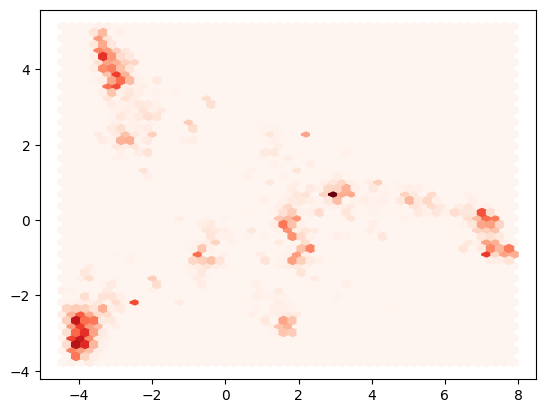

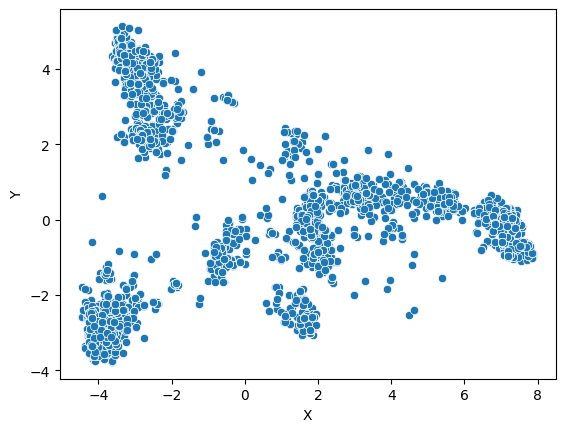

In [9]:
# уменьшаем размерность с помощью PCA и отображаем наши данные на графиках

vh_reduced_data = PCA(n_components=2).fit_transform(vh_df)

vh_embeddin_pos = pd.DataFrame(vh_reduced_data, columns=['X', 'Y'])

plt.hexbin(vh_embeddin_pos.X, vh_embeddin_pos.Y, cmap='Reds', gridsize=50)
plt.show()

sns.scatterplot(data=vh_embeddin_pos, x=vh_embeddin_pos.X, y=vh_embeddin_pos.Y)
plt.show()

In [10]:
vh_reduced_data

array([[-0.92793236, -1.23834888],
       [-0.92793236, -1.23834888],
       [-2.86105175,  3.63991486],
       ...,
       [-2.7895469 ,  4.46532916],
       [-2.7895469 ,  4.46532916],
       [-2.7895469 ,  4.46532916]])

### Кластеризация

Осуществим кластеризацию с помощью двух методов: K-means и агломеративной кластеризации.

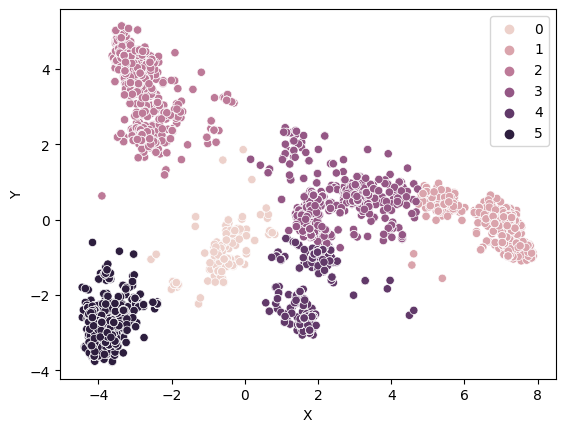

In [74]:
model = KMeans(n_init=5, init="k-means++", n_clusters=6)

model.fit(vh_embeddin_pos)
vh_clusters_kmeans = model.predict(vh_embeddin_pos)

sns.scatterplot(data=vh_embeddin_pos, x=vh_embeddin_pos.X, y=vh_embeddin_pos.Y, hue=vh_clusters_kmeans)
plt.show()

Метод K-средних показывает лучший вариант в данном случае.

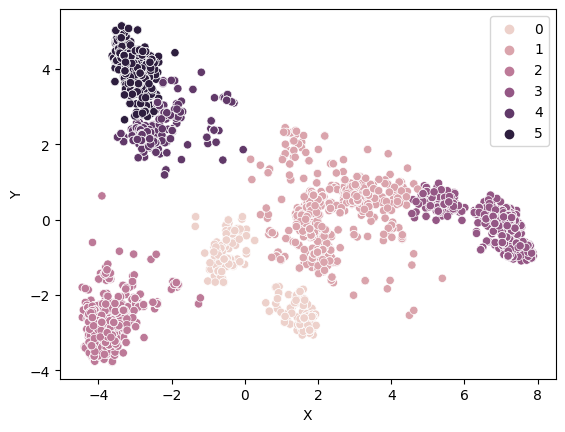

In [94]:
model = AgglomerativeClustering(n_clusters=6)
vh_clusters_agglomerative = model.fit_predict(vh_embeddin_pos)
sns.scatterplot(data=vh_embeddin_pos, x=vh_embeddin_pos.X, y=vh_embeddin_pos.Y, hue=vh_clusters_agglomerative)
plt.show()

С помощью Desicion_Tree составляем отчёт, в котором можно увидеть закономерности внутри полученных кластеров. Например, наличие определённой аминокислоты в конкретном месте последовательности.

In [75]:
cluster_report(vh_df, vh_clusters_kmeans, min_samples_leaf=20, pruning_level=0.04)

,class_name,instance_count,rule_list
5,0,371,[0.6260162601626016] (C:68 <= 0.5) and (T:78 <= 0.5) and (m:46 <= 0.939252108335495) and (P:38 > 0.5) and (H1:63 <= 0.022862331941723824)
3,1,1090,[0.956989247311828] (C:68 <= 0.5) and (T:78 <= 0.5) and (m:46 > 0.939252108335495)
1,2,1591,[0.927461139896373] (C:68 <= 0.5) and (T:78 > 0.5)
2,3,1109,[0.8889990089197225] (C:68 <= 0.5) and (T:78 <= 0.5) and (m:46 <= 0.939252108335495) and (P:38 <= 0.5)
4,4,513,[0.7861952861952862] (C:68 <= 0.5) and (T:78 <= 0.5) and (m:46 <= 0.939252108335495) and (P:38 > 0.5) and (H1:63 > 0.022862331941723824)
0,5,1696,[0.9568469505178366] (C:68 > 0.5)


In [76]:
model.labels_

array([0, 0, 2, ..., 2, 2, 2])

In [80]:
# можем посмотреть на последовательности, попавшие в определённый кластер

vh_df['labels'] = model.labels_
vh_df.loc[vh_df['labels'] == 3]

,A:1,R:1,N:1,D:1,C:1,Q:1,E:1,G:1,H:1,I:1,...,H1:130,H2:130,H3:130,v:130,P1:130,P2:130,S:130,n:130,m:130,labels
1fh5_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
1iga_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
1iga_B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
1mco_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
1mim_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8hcb_D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023627,0.01002,0.028479,0.395015,0.049047,0.01867,0.026607,0.018232,0.540746,3
8hcb_F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023627,0.01002,0.028479,0.395015,0.049047,0.01867,0.026607,0.018232,0.540746,3
8hcb_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023627,0.01002,0.028479,0.395015,0.049047,0.01867,0.026607,0.018232,0.540746,3
8hhy_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3


## VL-фрагменты

In [82]:
vl_np_array = np.load('light_output_part1_onehot.npy')
vl_np_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
vl_indices = []

with open('light_output_part1_keys.txt', 'r') as file:
    for line in file:
        vl_indices.append(line.rstrip('\n'))
    
#vl_indices

In [84]:
vl_columns = []

for i in range(1, 121):
    vl_columns.extend([f"A:{i}", f"R:{i}", f"N:{i}", f"D:{i}", f"C:{i}", f"Q:{i}", f"E:{i}", f"G:{i}", f"H:{i}", f"I:{i}", f"L:{i}"])
    vl_columns.extend([f"K:{i}", f"M:{i}", f"F:{i}", f"P:{i}", f"S:{i}", f"T:{i}", f"W:{i}", f"Y:{i}", f"V:{i}", f"H1:{i}", f"H2:{i}"])
    vl_columns.extend([f"H3:{i}", f"v:{i}", f"P1:{i}", f"P2:{i}", f"S:{i}", f"n:{i}", f"m:{i}"])

In [85]:
vl_df = pd.DataFrame(vl_np_array, index=vl_indices, columns=vl_columns)
pd.set_option('display.max_columns', 20)
vl_df

,A:1,R:1,N:1,D:1,C:1,Q:1,E:1,G:1,H:1,I:1,...,V:120,H1:120,H2:120,H3:120,v:120,P1:120,P2:120,S:120,n:120,m:120
1a8j_L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a8j_H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad0_A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad0_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad9_L,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8sb4_I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8sb4_N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8sb5_D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8sb5_I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Уменьшение размерности данных

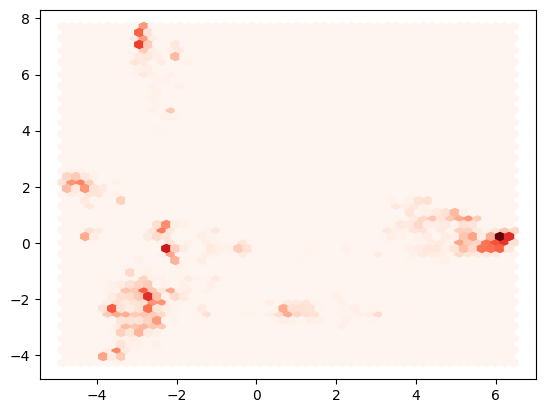

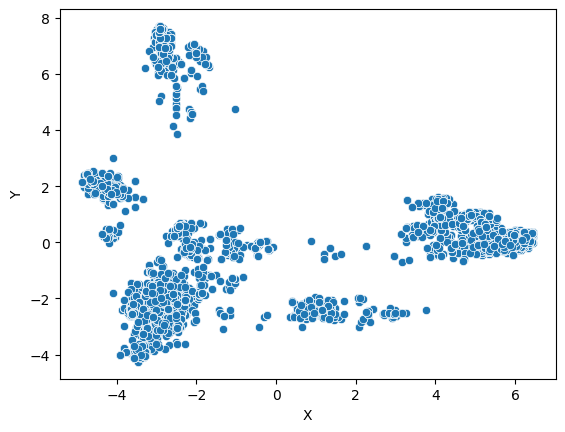

In [87]:
vl_reduced_data = PCA(n_components=2).fit_transform(vl_df)

vl_embeddin_pos = pd.DataFrame(vl_reduced_data, columns=['X', 'Y'])

plt.hexbin(vl_embeddin_pos.X, vl_embeddin_pos.Y, cmap='Reds', gridsize=50)
plt.show()

sns.scatterplot(data=vl_embeddin_pos, x=vl_embeddin_pos.X, y=vl_embeddin_pos.Y)
plt.show()

In [88]:
vl_reduced_data

array([[-4.23624258,  1.98674223],
       [-4.23624258,  1.98674223],
       [-1.51814047, -1.17969352],
       ...,
       [-3.61205029, -2.56101311],
       [-3.61205029, -2.56101311],
       [-3.61205029, -2.56101311]])

### Кластеризация

С помощью двух различных методов определим оптимальное количество кластеров. В совокупности методы однозначно указывают на значение 6.

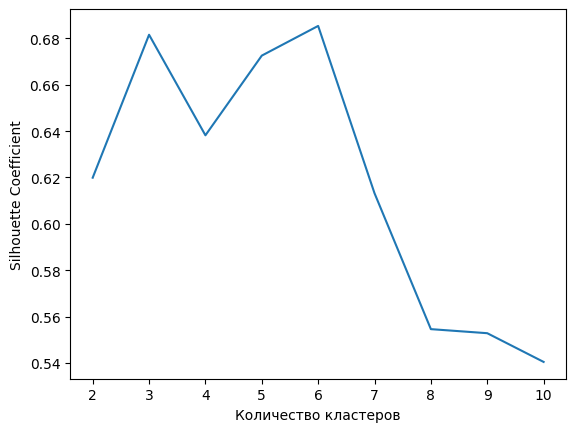

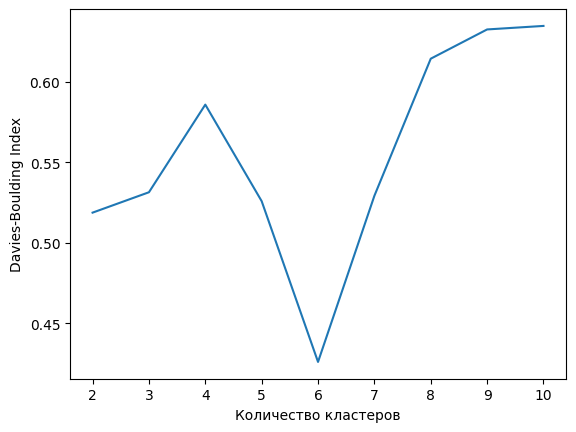

In [91]:
vl_silhouette_coefficients = []
vl_davies_bouldin = {}

for k in range(2, 11):
    kmeans = KMeans(n_init=10, init="k-means++", n_clusters=k)
    kmeans.fit(vl_embeddin_pos)
    score = silhouette_score(vl_embeddin_pos, kmeans.labels_)
    db_index = davies_bouldin_score(vl_embeddin_pos, kmeans.labels_)
    vl_silhouette_coefficients.append(score)
    vl_davies_bouldin.update({k: db_index})

plt.plot(range(2, 11), vl_silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette Coefficient")
plt.show()
 
plt.plot(list(vl_davies_bouldin.keys()), list(vl_davies_bouldin.values()))
plt.xlabel("Количество кластеров")
plt.ylabel("Davies-Boulding Index")
plt.show()

Осуществим кластеризацию с помощью двух методов: K-means и агломеративной кластеризации.

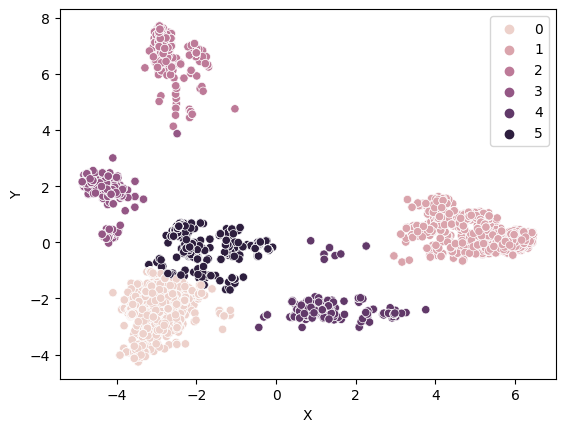

In [92]:
model = KMeans(n_init=10, init="k-means++", n_clusters=6)

model.fit(vl_embeddin_pos)
vl_clusters_kmeans = model.predict(vl_embeddin_pos)

sns.scatterplot(data=vl_embeddin_pos, x=vl_embeddin_pos.X, y=vl_embeddin_pos.Y, hue=vl_clusters_kmeans)
plt.show()

В этот раз лучший результат показывает метод агломеративной кластеризации.


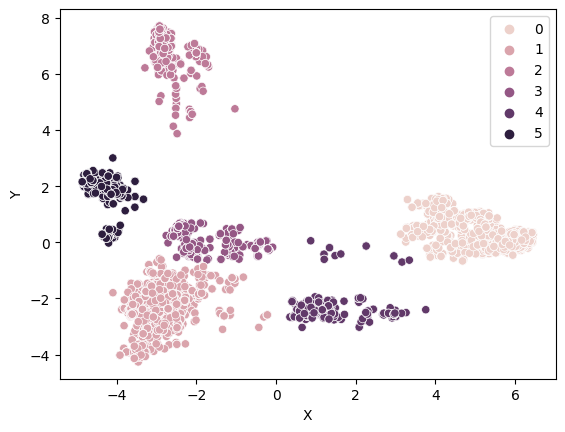

In [93]:
model = AgglomerativeClustering(n_clusters=6)
vl_clusters_agglomerative = model.fit_predict(vl_embeddin_pos)
sns.scatterplot(data=vl_embeddin_pos, x=vl_embeddin_pos.X, y=vl_embeddin_pos.Y, hue=vl_clusters_agglomerative)
plt.show()

In [96]:
# получаем отчёт

cluster_report(vl_df, vl_clusters_agglomerative, min_samples_leaf=20, pruning_level=0.03)

,class_name,instance_count,rule_list
1,0,2092,[0.943089430894309] (v:71 > 0.5993781089782715)
0,1,2132,[1.0] (v:71 <= 0.5993781089782715) and (R:23 <= 0.5) and (v:62 <= 0.5585054159164429)
3,2,651,[1.0] (v:71 <= 0.5993781089782715) and (R:23 > 0.5) and (v:42 <= 0.09044728614389896)
2,3,677,[0.9213483146067416] (v:71 <= 0.5993781089782715) and (R:23 > 0.5) and (v:42 > 0.09044728614389896)
5,4,411,[0.6921348314606741] (v:71 <= 0.5993781089782715) and (R:23 <= 0.5) and (v:62 > 0.5585054159164429) and (n:45 <= 0.01903502270579338)
4,5,592,[0.9983108108108109] (v:71 <= 0.5993781089782715) and (R:23 <= 0.5) and (v:62 > 0.5585054159164429) and (n:45 > 0.01903502270579338)
